In [ ]:
#!nvidia-smi

In [ ]:
!pip install git+https://github.com/mrava87/pylops.git@feature-jax > /dev/null

  Running command git clone --filter=blob:none --quiet https://github.com/mrava87/pylops.git /tmp/pip-req-build-63z4xs_5
  Running command git checkout -b feature-jax --track origin/feature-jax
  Switched to a new branch 'feature-jax'
  Branch 'feature-jax' set up to track remote branch 'feature-jax' from 'origin'.


In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import timeit
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
import seaborn as sns

import pylops
import jax.numpy as jnp
import jax

from jax.lib import xla_bridge
from pylops import LinearOperator, JaxOperator
from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *
from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity import irls as irlspylops
from pylops.optimization.sparsity import fista, spgl1

os.environ["JAX_PYLOPS"] = '1'

print(xla_bridge.get_backend().platform)

gpu


In [ ]:
def timing(cmd_setup, df, method):
    # _matvec
    mat_np = 'Op._matvec(x)'
    mat_cp = 'cOp._matvec(xc)'
    mat_jp = '(jOp._matvec(xp)).block_until_ready()'

    # _matvec
    rmat_np = 'Op._rmatvec(y)'
    rmat_cp = 'cOp._rmatvec(yc)'
    rmat_jp = '(jOp._rmatvec(yp)).block_until_ready()'

    # dry run
    timeit.repeat(mat_cp, setup=cmd_setup, number=1, repeat=1)
    timeit.repeat(rmat_cp, setup=cmd_setup, number=1, repeat=1)

    timeit.repeat(mat_jp, setup=cmd_setup, number=1, repeat=1)
    timeit.repeat(rmat_jp, setup=cmd_setup, number=1, repeat=1)

    # timing
    tm_ = 1.e3 * np.array(timeit.repeat(mat_np, setup=cmd_setup,
                                        number=10, repeat=5))
    trm_ = 1.e3 * np.array(timeit.repeat(rmat_np, setup=cmd_setup,
                                         number=10, repeat=5))
    for i in range(5):
        df.loc[len(df)] = [method, True, 'np', tm_[i]]
    for i in range(5):
        df.loc[len(df)] = [method, False, 'np', + trm_[i]]

    tm_ = 1.e3 * np.array(timeit.repeat(mat_cp, setup=cmd_setup,
                                      number=10, repeat=5))
    trm_ = 1.e3 * np.array(timeit.repeat(rmat_cp, setup=cmd_setup,
                                      number=10, repeat=5))
    for i in range(5):
        df.loc[len(df)] = [method, True, 'cp', tm_[i]]
    for i in range(5):
        df.loc[len(df)] = [method, False, 'cp', trm_[i]]

    tm_ = 1.e3 * np.array(timeit.repeat(mat_jp, setup=cmd_setup,
                                        number=10, repeat=5))
    trm_ = 1.e3 * np.array(timeit.repeat(rmat_jp, setup=cmd_setup,
                                         number=10, repeat=5))
    for i in range(5):
        df.loc[len(df)] = [method, True, 'jp', tm_[i]]
    for i in range(5):
        df.loc[len(df)] = [method, False, 'jp', trm_[i]]

    return df

In [ ]:
df = pd.DataFrame(columns=['Method', 'Forw', 'Backend', 'Time'])

## Diagonal

In [ ]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import jax.numpy as jnp
import pylops
from pylops import LinearOperator, JaxOperator

n = 2500000
d = np.arange(n, dtype='float32') + 1.
dp = jnp.ones(n, dtype='float32') + 1.
y = x = np.ones(n, dtype='float32')
yc = xc = cp.ones(n, dtype='float32')
yp = xp = jnp.ones(n, dtype='float32')
Op = pylops.Diagonal(d)
cOp = pylops.Diagonal(cp.array(d))
jOp = JaxOperator(pylops.Diagonal(dp, dtype='float32'))

(jOp._matvec(xp)).block_until_ready()
(jOp._rmatvec(yp)).block_until_ready()
"""

df = timing(cmd_setup, df, 'Diagonal')

## Identity

In [ ]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import jax.numpy as jnp
import pylops
from pylops import LinearOperator, JaxOperator

n = 2500000
y = x = np.ones(n, dtype='float32')
yc = xc = cp.ones(n, dtype='float32')
yp = xp = jnp.ones(n, dtype='float32')
Op = pylops.Identity(n)
cOp = pylops.Identity(n, dtype='float32')
jOp = JaxOperator(pylops.Identity(n, dtype='float32'))

(jOp._matvec(xp)).block_until_ready()
(jOp._rmatvec(yp)).block_until_ready()
"""

df = timing(cmd_setup, df, 'Identity')

## MatrixMult

In [ ]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import jax.numpy as jnp
import pylops
from pylops import LinearOperator, JaxOperator

n = 500
D = np.ones((n, n), dtype='float32')
Dp = jnp.ones((n, n), dtype='float32')
y = x = np.ones(n, dtype='float32')
yc = xc = cp.ones(n, dtype='float32')
yp = xp = jnp.ones(n, dtype='float32')

Op = pylops.MatrixMult(D, dtype='float32')
cOp = pylops.MatrixMult(cp.array(D), dtype='float32')
jOp = JaxOperator(pylops.MatrixMult(Dp, dtype='float32'))

(jOp._matvec(xp)).block_until_ready()
(jOp._rmatvec(yp)).block_until_ready()
"""

df = timing(cmd_setup, df, 'MatrixMult')

## Zero

In [ ]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import jax.numpy as jnp
import pylops
from pylops import LinearOperator, JaxOperator

ny, nx = int(1e6), int(1e6)
y = x = np.arange(nx, dtype='float32')
yc = xc = cp.ones(nx, dtype='float32')
yp = xp = jnp.ones(nx, dtype='float32')

Op = pylops.Zero(ny, nx, dtype='float32')
cOp = pylops.Zero(ny, nx, dtype='float32')
jOp = JaxOperator(pylops.Zero(ny, nx, dtype='float32'))

(jOp._matvec(xp)).block_until_ready()
(jOp._rmatvec(yp)).block_until_ready()
"""

df = timing(cmd_setup, df, 'Zero')

# Sum

In [ ]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import jax.numpy as jnp
import pylops
from pylops import LinearOperator, JaxOperator

ny, nx = 1000, 1000
x = np.ones(nx*ny, dtype='float32')
xc = cp.ones(nx*ny, dtype='float32')
xp = jnp.ones(nx*ny, dtype='float32')
y = np.ones(nx, dtype='float32')
yc = cp.ones(nx, dtype='float32')
yp = jnp.ones(nx, dtype='float32')

Op = pylops.Sum(dims=(ny, nx), axis=0, dtype='float32')
cOp = pylops.Sum(dims=(ny, nx), axis=0,  dtype='float32')
jOp = JaxOperator(pylops.Sum(dims=(ny, nx), axis=0, dtype='float32'))

(jOp._matvec(xp)).block_until_ready()
(jOp._rmatvec(yp)).block_until_ready()
"""

df = timing(cmd_setup, df, 'Sum')

# Flip

In [ ]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import jax.numpy as jnp
import pylops
from pylops import LinearOperator, JaxOperator

ny, nx = 500, 500
x = np.ones(nx*ny, dtype='float32')
xc = cp.ones(nx*ny, dtype='float32')
xp = jnp.ones(nx*ny, dtype='float32')
y = np.ones(nx*ny, dtype='float32')
yc = cp.ones(nx*ny, dtype='float32')
yp = jnp.ones(nx*ny, dtype='float32')

Op = pylops.Flip((ny, nx), axis=1, dtype='float32')
cOp = pylops.Flip((ny, nx), axis=1, dtype='float32')
jOp = JaxOperator(pylops.Flip((ny, nx), axis=1, dtype='float32'))

(jOp._matvec(xp)).block_until_ready()
(jOp._rmatvec(yp)).block_until_ready()
"""

df = timing(cmd_setup, df, 'Flip')

# Pad

In [ ]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import jax.numpy as jnp
import pylops
from pylops import LinearOperator, JaxOperator

n = int(1e3)
pad = (200, 200)
x = np.ones(n, dtype='float32')
xc = cp.ones(n, dtype='float32')
xp = jnp.ones(n, dtype='float32')
y = np.ones(n + 400, dtype='float32')
yc = cp.ones(n + 400, dtype='float32')
yp = jnp.ones(n + 400, dtype='float32')

Op = pylops.Pad(n, pad, dtype='float32')
cOp = pylops.Pad(n, pad, dtype='float32')
jOp = JaxOperator(pylops.Pad(n, pad, dtype='float32'))

(jOp._matvec(xp)).block_until_ready()
(jOp._rmatvec(yp)).block_until_ready()
"""

df = timing(cmd_setup, df, 'Pad')

# Roll

In [ ]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import jax.numpy as jnp
import pylops
from pylops import LinearOperator, JaxOperator

n = int(1e6)
y = x = np.arange(n, dtype='float32')
yc = xc = cp.ones(n, dtype='float32')
yp = xp = jnp.ones(n, dtype='float32')

Op = pylops.Roll(n, shift=20, dtype='float32')
cOp = pylops.Roll(n, shift=20, dtype='float32')
jOp = JaxOperator(pylops.Roll(n, shift=20, dtype='float32'))

(jOp._matvec(xp)).block_until_ready()
(jOp._rmatvec(yp)).block_until_ready()
"""

df = timing(cmd_setup, df, 'Roll')

# Symmetrize

In [ ]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import jax.numpy as jnp
import pylops
from pylops import LinearOperator, JaxOperator

n = int(1e6)
x = np.arange(n, dtype='float32')
xc = cp.ones(n, dtype='float32')
xp = jnp.ones(n, dtype='float32')
y = np.arange(n*2-1, dtype='float32')
yc = cp.ones(n*2-1, dtype='float32')
yp = jnp.ones(n*2-1, dtype='float32')

Op = pylops.Symmetrize(n, dtype='float32')
cOp = pylops.Symmetrize(n, dtype='float32')
jOp = JaxOperator(pylops.Symmetrize(n, dtype='float32'))

(jOp._matvec(xp)).block_until_ready()
(jOp._rmatvec(yp)).block_until_ready()
"""

df = timing(cmd_setup, df, 'Symmetrize')

# Transpose

In [ ]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import jax.numpy as jnp
import pylops
from pylops import LinearOperator, JaxOperator

ny, nx = 1000, 1000
n = ny*nx
y = x = np.arange(n, dtype='float32')
yc = xc = cp.ones(n, dtype='float32')
yp = xp = jnp.ones(n, dtype='float32')

Op = pylops.Transpose((ny, nx), axes=(1,0), dtype='float32')
cOp = pylops.Transpose((ny, nx), axes=(1,0), dtype='float32')
jOp = JaxOperator(pylops.Transpose((ny, nx), axes=(1,0), dtype='float32'))

(jOp._matvec(xp)).block_until_ready()
(jOp._rmatvec(yp)).block_until_ready()
"""

df = timing(cmd_setup, df, 'Transpose')

# FirstDerivative

In [ ]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import jax.numpy as jnp
import pylops
from pylops import LinearOperator, JaxOperator

ny, nx = 500, 500
x = np.ones(nx*ny, dtype='float32')
xc = cp.ones(nx*ny, dtype='float32')
xp = jnp.ones(nx*ny, dtype='float32')
y = np.ones(nx*ny, dtype='float32')
yc = cp.ones(nx*ny, dtype='float32')
yp = jnp.ones(nx*ny, dtype='float32')

Op = pylops.FirstDerivative((ny, nx), axis=0, kind='forward', edge=True, dtype='float32')
cOp = pylops.FirstDerivative((ny, nx), axis=0, kind='forward', edge=True, dtype='float32')
jOp = JaxOperator(pylops.FirstDerivative((ny, nx), axis=0, kind='forward', edge=True, dtype='float32'))

(jOp._matvec(xp)).block_until_ready()
(jOp._rmatvec(yp)).block_until_ready()
"""
df = timing(cmd_setup, df, 'FirstDerivative')

# Causal integration

In [ ]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import jax.numpy as jnp
import pylops
from pylops import LinearOperator, JaxOperator

ny, nx = 500, 500
x = np.ones(nx*ny, dtype='float32')
xc = cp.ones(nx*ny, dtype='float32')
xp = jnp.ones(nx*ny, dtype='float32')
y = np.ones(nx*ny, dtype='float32')
yc = cp.ones(nx*ny, dtype='float32')
yp = jnp.ones(nx*ny, dtype='float32')

Op = pylops.CausalIntegration((ny, nx), axis=1, dtype='float32')
cOp = pylops.CausalIntegration((ny, nx), axis=1, dtype='float32')
jOp = JaxOperator(pylops.CausalIntegration((ny, nx), axis=1, dtype='float32'))

(jOp._matvec(xp)).block_until_ready()
(jOp._rmatvec(yp)).block_until_ready()
"""
df = timing(cmd_setup, df, 'CausalIntegration')

# FFT

In [ ]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import jax.numpy as jnp
import pylops
from pylops import LinearOperator, JaxOperator

n = 250000
x = np.ones(n, dtype='float32')
xc = cp.ones(n, dtype='float32')
xp = jnp.ones(n, dtype='float32')
y = np.ones(n, dtype='float32')
yc = cp.ones(n, dtype='float32')
yp = jnp.ones(n, dtype='float32')

Op = pylops.signalprocessing.FFT(dims=[n], nfft=n, dtype='float32')
cOp = pylops.signalprocessing.FFT(dims=[n], nfft=n, dtype='float32')
jOp = JaxOperator(pylops.signalprocessing.FFT(dims=[n], nfft=n, dtype='float32'))

(jOp._matvec(xp)).block_until_ready()
(jOp._rmatvec(yp)).block_until_ready()
"""
df = timing(cmd_setup, df, 'FFT')

/usr/local/lib/python3.10/dist-packages/pylops/signalprocessing/fft.py:53: UserWarning: numpy backend always returns complex128 dtype. To respect the passed dtype, data will be casted to complex64.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pylops/signalprocessing/fft.py:53: UserWarning: numpy backend always returns complex128 dtype. To respect the passed dtype, data will be casted to complex64.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pylops/signalprocessing/fft.py:53: UserWarning: numpy backend always returns complex128 dtype. To respect the passed dtype, data will be casted to complex64.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pylops/signalprocessing/fft.py:53: UserWarning: numpy backend always returns complex128 dtype. To respect the passed dtype, data will be casted to complex64.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pylops/signalprocessing/fft.py:53: UserWarning: numpy backend always returns complex128 dtype. To re

# FFT2D

In [ ]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import jax.numpy as jnp
import pylops
from pylops import LinearOperator, JaxOperator

ny, nx = 500, 500
x = np.ones(nx*ny, dtype='float32')
xc = cp.ones(nx*ny, dtype='float32')
xp = jnp.ones(nx*ny, dtype='float32')
y = np.ones(nx*ny, dtype='float32')
yc = cp.ones(nx*ny, dtype='float32')
yp = jnp.ones(nx*ny, dtype='float32')

Op = pylops.signalprocessing.FFT2D(dims=[ny, nx], dtype='float32')
cOp = pylops.signalprocessing.FFT2D(dims=[ny, nx], dtype='float32')
jOp = JaxOperator(pylops.signalprocessing.FFT2D(dims=[ny, nx], dtype='float32'))

(jOp._matvec(xp)).block_until_ready()
(jOp._rmatvec(yp)).block_until_ready()
"""
df = timing(cmd_setup, df, 'FFT2D')

/usr/local/lib/python3.10/dist-packages/pylops/signalprocessing/fft2d.py:46: UserWarning: numpy backend always returns complex128 dtype. To respect the passed dtype, data will be casted to complex64.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pylops/signalprocessing/fft2d.py:46: UserWarning: numpy backend always returns complex128 dtype. To respect the passed dtype, data will be casted to complex64.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pylops/signalprocessing/fft2d.py:46: UserWarning: numpy backend always returns complex128 dtype. To respect the passed dtype, data will be casted to complex64.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pylops/signalprocessing/fft2d.py:46: UserWarning: numpy backend always returns complex128 dtype. To respect the passed dtype, data will be casted to complex64.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pylops/signalprocessing/fft2d.py:46: UserWarning: numpy backend always returns complex128 dt

# FFTND

In [ ]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import jax.numpy as jnp
import pylops
from pylops import LinearOperator, JaxOperator

nz, ny, nx = 50, 100, 100
x = np.ones(nz*nx*ny, dtype='float32')
xc = cp.ones(nz*nx*ny, dtype='float32')
xp = jnp.ones(nz*nx*ny, dtype='float32')
y = np.ones(nz*nx*ny, dtype='float32')
yc = cp.ones(nz*nx*ny, dtype='float32')
yp = jnp.ones(nz*nx*ny, dtype='float32')

Op = pylops.signalprocessing.FFTND(dims=[nz, ny, nx], engine='numpy', dtype='float32')
cOp = pylops.signalprocessing.FFTND(dims=[nz, ny, nx], engine='numpy', dtype='float32')
jOp = JaxOperator(pylops.signalprocessing.FFTND(dims=[nz, ny, nx], engine='numpy', dtype='float32'))

(jOp._matvec(xp)).block_until_ready()
(jOp._rmatvec(yp)).block_until_ready()
"""
df = timing(cmd_setup, df, 'FFTND')

/usr/local/lib/python3.10/dist-packages/pylops/signalprocessing/fftnd.py:47: UserWarning: numpy backend always returns complex128 dtype. To respect the passed dtype, data will be cast to complex64.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pylops/signalprocessing/fftnd.py:47: UserWarning: numpy backend always returns complex128 dtype. To respect the passed dtype, data will be cast to complex64.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pylops/signalprocessing/fftnd.py:47: UserWarning: numpy backend always returns complex128 dtype. To respect the passed dtype, data will be cast to complex64.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pylops/signalprocessing/fftnd.py:47: UserWarning: numpy backend always returns complex128 dtype. To respect the passed dtype, data will be cast to complex64.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pylops/signalprocessing/fftnd.py:47: UserWarning: numpy backend always returns complex128 dtype. To 

# Convolve1D

In [ ]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import jax.numpy as jnp
import pylops
from pylops import LinearOperator, JaxOperator

n = 250000
x = np.ones(n, dtype='float32')
xc = cp.ones(n, dtype='float32')
xp = jnp.ones(n, dtype='float32')
y = np.ones(n, dtype='float32')
yc = cp.ones(n, dtype='float32')
yp = jnp.ones(n, dtype='float32')
h = np.ones(40, dtype='float32')
hc = cp.ones(40, dtype='float32')
hp = jnp.ones(40, dtype='float32')

Op = pylops.signalprocessing.Convolve1D(n, h, dtype='float32')
cOp = pylops.signalprocessing.Convolve1D(n, hc, dtype='float32')
jOp = JaxOperator(pylops.signalprocessing.Convolve1D(n, hp, dtype='float32'))

(jOp._matvec(xp)).block_until_ready()
(jOp._rmatvec(yp)).block_until_ready()

"""
df = timing(cmd_setup, df, 'Convolve1D')

# Convolve2D

In [ ]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import jax.numpy as jnp
import pylops
from pylops import LinearOperator, JaxOperator

nt, nx = 1000, 1000
x = np.ones(nt*nx, dtype='float32')
xc = cp.ones(nt*nx, dtype='float32')
xp = jnp.ones(nt*nx, dtype='float32')
y = np.ones(nt*nx, dtype='float32')
yc = cp.ones(nt*nx, dtype='float32')
yp = jnp.ones(nt*nx, dtype='float32')
h = np.ones((5,5), dtype='float32')
hc = cp.ones((5,5), dtype='float32')
hp = jnp.ones((5,5), dtype='float32')

Op = pylops.signalprocessing.Convolve2D((nt, nx), h, dtype='float32')
cOp = pylops.signalprocessing.Convolve2D((nt, nx), hc, dtype='float32')
jOp = JaxOperator(pylops.signalprocessing.Convolve2D((nt, nx), hp, dtype='float32'))

(jOp._matvec(xp)).block_until_ready()
(jOp._rmatvec(yp)).block_until_ready()

"""
df = timing(cmd_setup, df, 'Convolve2D')

# ConvolveND

In [ ]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import jax.numpy as jnp
import pylops
from pylops import LinearOperator, JaxOperator

nt, ny, nx = 100, 100, 100
x = np.ones(nt*ny*nx, dtype='float32')
xc = cp.ones(nt*ny*nx, dtype='float32')
xp = jnp.ones(nt*ny*nx, dtype='float32')
y = np.ones(nt*ny*nx, dtype='float32')
yc = cp.ones(nt*ny*nx, dtype='float32')
yp = jnp.ones(nt*ny*nx, dtype='float32')
h = np.ones((10, 10, 10), dtype='float32')
hc = cp.ones((10, 10, 10), dtype='float32')
hp = jnp.ones((10, 10, 10), dtype='float32')

Op = pylops.signalprocessing.ConvolveND((nt, ny, nx), h, dtype='float32')
cOp = pylops.signalprocessing.ConvolveND((nt, ny, nx), hc, dtype='float32')
jOp = JaxOperator(pylops.signalprocessing.ConvolveND((nt, ny, nx), hp, dtype='float32'))

(jOp._matvec(xp)).block_until_ready()
(jOp._rmatvec(yp)).block_until_ready()

"""
df = timing(cmd_setup, df, 'ConvolveND')

# NonStationaryConvolve1D

In [ ]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import jax.numpy as jnp
import pylops
from pylops import LinearOperator, JaxOperator
from pylops.utils.wavelets import ricker

n = 101
wav = np.ones(11)
wavs = np.stack([wav, wav]).astype('float32')

x = np.ones(n, dtype='float32')
xc = cp.ones(n, dtype='float32')
xp = jnp.ones(n, dtype='float32')
y = np.ones(n, dtype='float32')
yc = cp.ones(n, dtype='float32')
yp = jnp.ones(n, dtype='float32')
wavsc = cp.asarray(wavs)
wavsp = jnp.array(wavs)

Op = pylops.signalprocessing.NonStationaryConvolve1D(dims=n, hs=wavs, ih=(21, 41), dtype='float32')
cOp = pylops.signalprocessing.NonStationaryConvolve1D(dims=n, hs=wavsc, ih=(21, 41), dtype='float32')
jOp = JaxOperator(pylops.signalprocessing.NonStationaryConvolve1D(dims=n, hs=wavsp, ih=(21, 41), dtype='float32'))

(jOp._matvec(xp)).block_until_ready()
(jOp._rmatvec(yp)).block_until_ready()

"""
df = timing(cmd_setup, df, 'NonStationaryConvolve1D')

# Fredholm1

In [ ]:
# setup command
cmd_setup ="""\
import numpy as np
import cupy as cp
import jax.numpy as jnp
import pylops
from pylops import LinearOperator, JaxOperator

nt, nh1, nh2, nz = 100, 1000, 700, 500
h = np.ones((nt, nh1, nh2), dtype='float32')
hc = cp.ones((nt, nh1, nh2), dtype='float32')
hp = jnp.ones((nt, nh1, nh2), dtype='float32')

x = np.ones(nt*nz*nh2, dtype='float32')
xc = cp.ones(nt*nz*nh2, dtype='float32')
xp = jnp.ones(nt*nz*nh2, dtype='float32')

y = np.ones(nt*nh1*nz, dtype='float32')
yc = cp.ones(nt*nh1*nz, dtype='float32')
yp = jnp.ones(nt*nh1*nz, dtype='float32')

Op = pylops.signalprocessing.Fredholm1(h, nz, dtype='float32')
cOp = pylops.signalprocessing.Fredholm1(hc, nz, dtype='float32')
jOp = JaxOperator(pylops.signalprocessing.Fredholm1(hp, nz, dtype='float32'))

(jOp._matvec(xp)).block_until_ready()
(jOp._rmatvec(yp)).block_until_ready()

"""
df = timing(cmd_setup, df, 'Fredholm1')

# Visualization

<ipython-input-32-c4c17e6d232e>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df['Method'].unique(),rotation=45, fontsize=9)
<ipython-input-32-c4c17e6d232e>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df['Method'].unique(),rotation=45, fontsize=9);


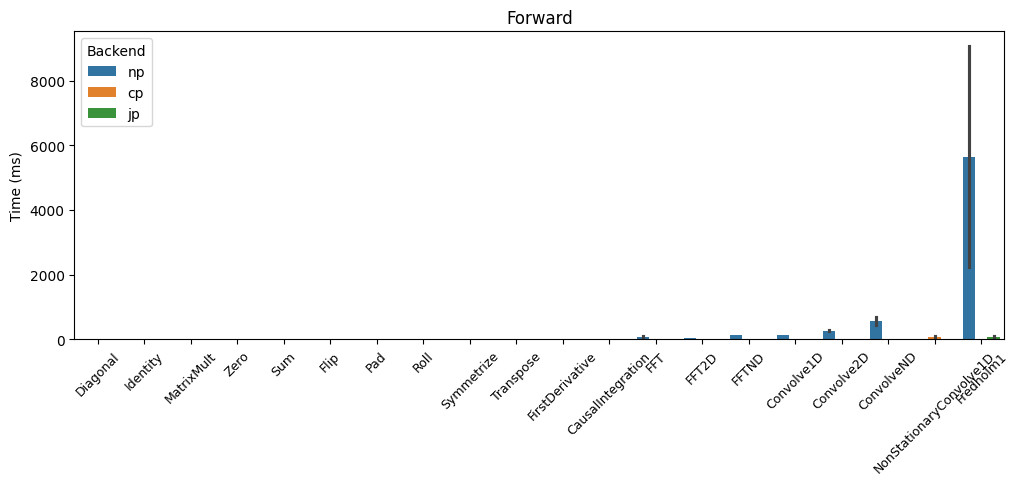

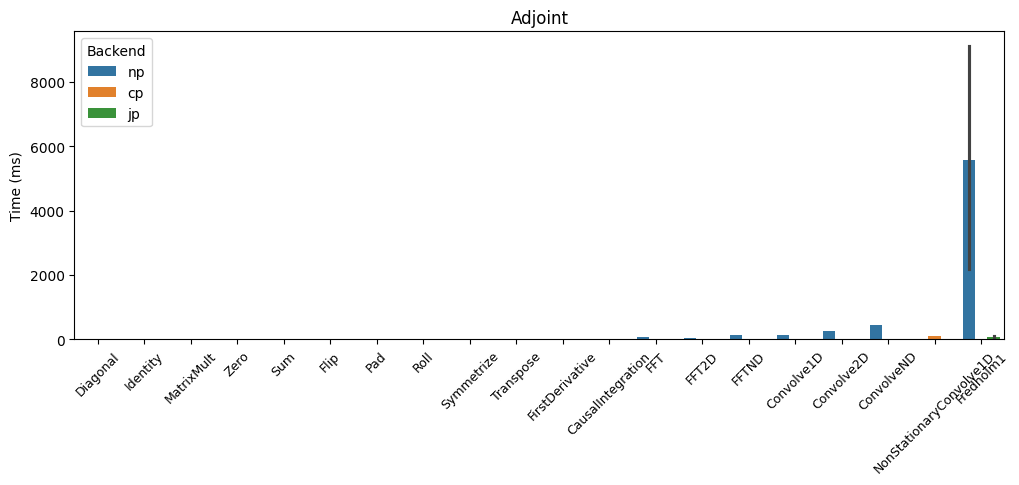

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.barplot(x='Method', y='Time', hue='Backend', data=df[df['Forw']==True])
ax.set_xlabel('');
ax.set_ylabel('Time (ms)')
ax.set_title('Forward')
ax.set_xticklabels(df['Method'].unique(),rotation=45, fontsize=9)

fig, ax = plt.subplots(figsize=(12, 4))
sns.barplot(x='Method', y='Time', hue='Backend', data=df[df['Forw']==False])
ax.set_xlabel('');
ax.set_ylabel('Time (ms)')
ax.set_title('Adjoint')
ax.set_xticklabels(df['Method'].unique(),rotation=45, fontsize=9);

<ipython-input-33-7f41b03e35d7>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_nonp['Method'].unique(),rotation=45, fontsize=9)
<ipython-input-33-7f41b03e35d7>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_nonp['Method'].unique(),rotation=45, fontsize=9);


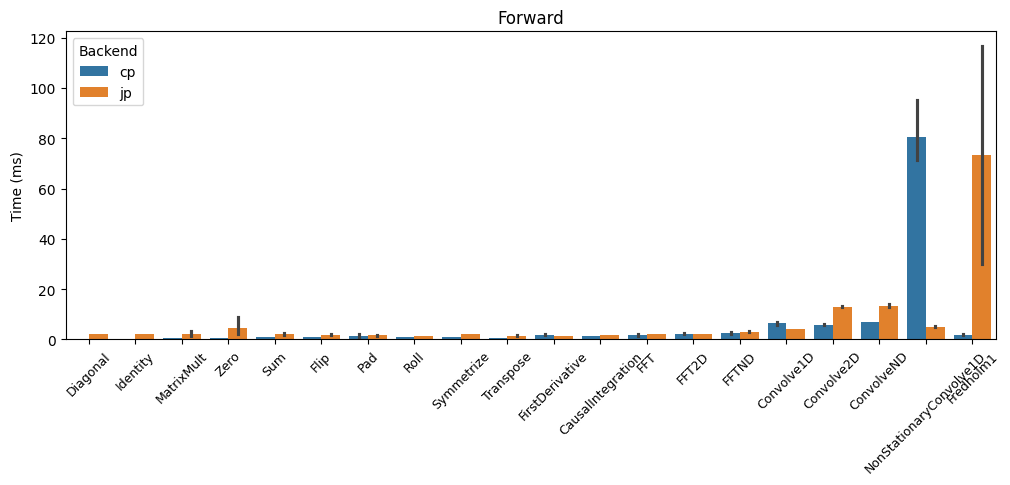

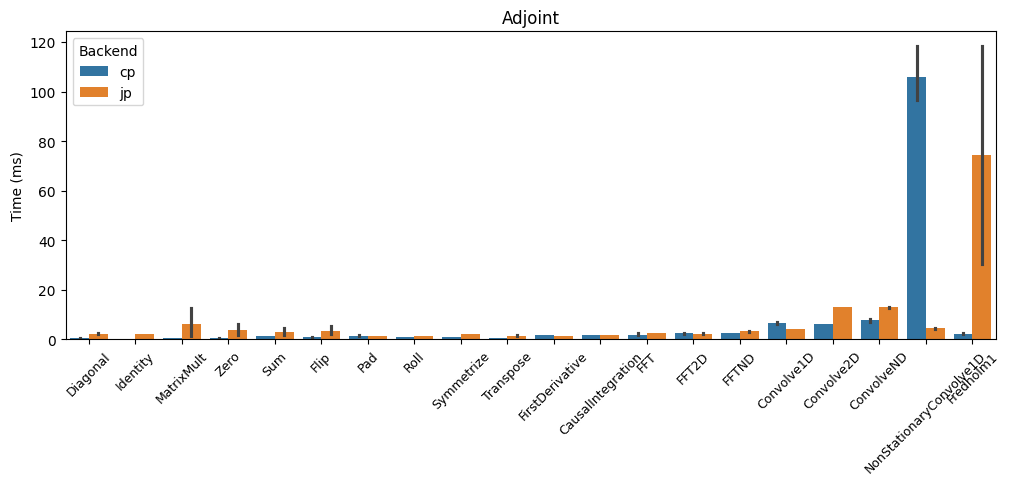

In [ ]:
df_nonp = df.drop(df[df['Backend'] == 'np'].index)

fig, ax = plt.subplots(figsize=(12, 4))
sns.barplot(x='Method', y='Time', hue='Backend', data=df_nonp[df_nonp['Forw']==True])
ax.set_xlabel('');
ax.set_ylabel('Time (ms)')
ax.set_title('Forward')
ax.set_xticklabels(df_nonp['Method'].unique(),rotation=45, fontsize=9)

fig, ax = plt.subplots(figsize=(12, 4))
sns.barplot(x='Method', y='Time', hue='Backend', data=df_nonp[df_nonp['Forw']==False])
ax.set_xlabel('');
ax.set_ylabel('Time (ms)')
ax.set_title('Adjoint')
ax.set_xticklabels(df_nonp['Method'].unique(),rotation=45, fontsize=9);

In [ ]:
df_comp_cp = df[df['Backend'] == 'cp']
df_comp_jp = df[df['Backend'] == 'jp']

df_comp_cp = df_comp_cp[['Method', 'Forw', 'Time']]
df_comp_jp = df_comp_jp[['Method', 'Forw', 'Time']]

df_comp_speedup1 = df_comp_cp.groupby(['Method', 'Forw']).mean() / df_comp_jp.groupby(['Method', 'Forw']).mean()
df_comp_speedup1 = pd.DataFrame(df_comp_speedup1.to_records())
df_comp_speedup1['Forw'] = df_comp_speedup1['Forw'].map({True: 'Forw', False: 'Adj'})
df_comp_speedup1 = df_comp_speedup1.rename(columns={'Time': 'Speedup', 'Forw':'Kind'})

print(df_comp_speedup1)

                     Method  Kind    Speedup
0         CausalIntegration   Adj   1.078802
1         CausalIntegration  Forw   0.765045
2                Convolve1D   Adj   1.612142
3                Convolve1D  Forw   1.526166
4                Convolve2D   Adj   0.476583
5                Convolve2D  Forw   0.450433
6                ConvolveND   Adj   0.589429
7                ConvolveND  Forw   0.515832
8                  Diagonal   Adj   0.161411
9                  Diagonal  Forw   0.153956
10                      FFT   Adj   0.793178
11                      FFT  Forw   0.733164
12                    FFT2D   Adj   1.045889
13                    FFT2D  Forw   1.112288
14                    FFTND   Adj   0.797202
15                    FFTND  Forw   0.802263
16          FirstDerivative   Adj   1.184581
17          FirstDerivative  Forw   1.420300
18                     Flip   Adj   0.272048
19                     Flip  Forw   0.481544
20                Fredholm1   Adj   0.029457
21        

<ipython-input-35-70db6cb7273b>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_comp_speedup1['Method'].unique(),rotation=45, fontsize=9);


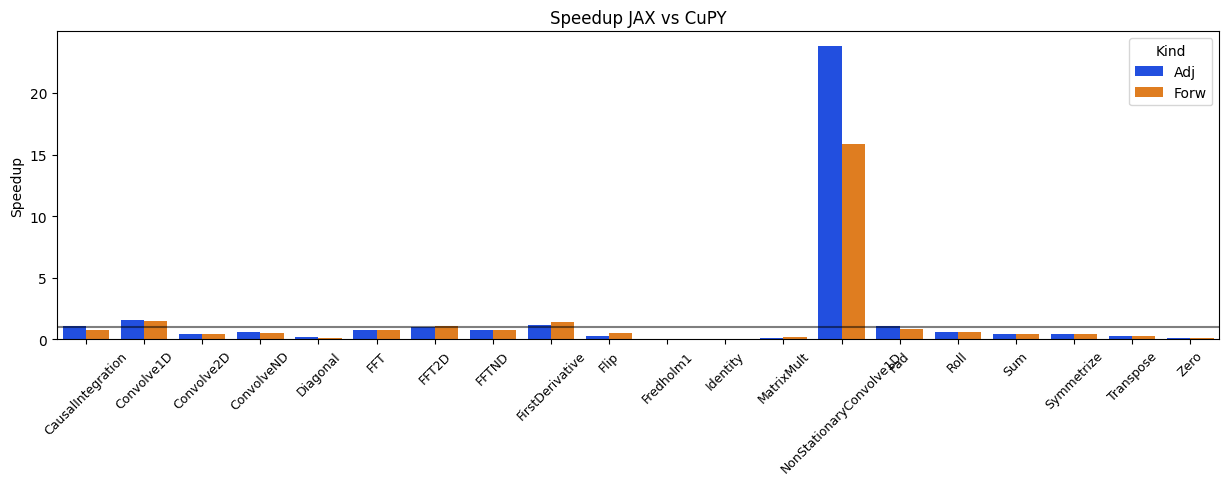

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
sns.barplot(x='Method', y='Speedup', hue='Kind', data=df_comp_speedup1, palette="bright", ax=ax)
ax.axhline(1, color='k', alpha=0.5)
ax.set_xlabel('')
ax.set_title('Speedup JAX vs CuPY')
ax.set_xticklabels(df_comp_speedup1['Method'].unique(),rotation=45, fontsize=9);